In [2]:
pip install eli5

  Using cached eli5-0.10.1-py2.py3-none-any.whl (105 kB)
  Using cached tabulate-0.8.7-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import eli5
from mpl_toolkits import mplot3d 
from sklearn.linear_model import LogisticRegression
import time
from sklearn.manifold import TSNE
import eli5
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
# import dabl

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Allow more rows to be printed to investigate feature importance
pd.set_option('display.max_rows', 300)

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}


# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

/Users/q3/opt/anaconda3/envs/lrp/lib/python3.6/site-packages/ipykernel_launcher.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
netcdf_path = (PROJ_PATH / 'internship'/'FieldPolygons2019_stats').with_suffix('.nc') 
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 401 ms


In [8]:
ds.close()

time: 76.3 ms


In [9]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns= ['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 18.1 s


In [10]:
class_names = ['Potato',
 'Spring barley',
 'Winter barley',
 'Spring wheat',
 'Winter wheat',
 'Winter rye',
 'Spring oat',
 'Maize',
 'Rapeseed',
 'Permanent grass',
 'Willow',
 'Forest']

time: 327 ms


In [11]:
def get_X_y(satellite_type):
    
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-01-01', '2019-12-31'), 
                                fields='all', 
                                satellite=satellite_type, 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")
    
    scaler = StandardScaler() 
    df_sklearn_remapped.iloc[:,5:] = scaler.fit_transform(df_sklearn_remapped.iloc[:,5:])
    
    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'
    return X, y, df_sklearn_remapped

time: 117 ms


In [14]:
def LDA_model(dimensions, data, y):
    model = LDA(n_components = dimensions)
    X_lda = model.fit_transform(data, y)
    print('Explained variation per principal component : {}'.format(model.explained_variance_ratio_))
    return model, X_lda

time: 83.6 ms


In [15]:
def LDA_model_lineplot(dimensions, data, y):
    model = LDA(n_components = dimensions)
    X_lda = model.fit_transform(data, y)
    #print('Explained variation per principal component: {}'.format(model.explained_variance_ratio_))
    variance = model.explained_variance_ratio_ #calculate variance ratios
    var=np.cumsum(np.round(model.explained_variance_ratio_, decimals=3)*100)
    print(list(var))
    #var #cumulative sum of variance explained with [n] features
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    #plt.xticks(rotation=90, horizontalalignment='center')
    plt.title('LDA Analysis')
    plt.ylim(30,100.5)
    plt.style.context('seaborn-whitegrid')


    plt.plot(var)

time: 131 ms


In [19]:
def LDA_plot_2D(X_lda, df_sklearn_remapped, crops,category):
    principalDf = pd.DataFrame(data = X_lda
                 , columns = ['LDA component 1', 'LDA component 2'])
    finalDf = pd.concat([principalDf, df_sklearn_remapped[['Crop type']]], axis = 1)
    finalDf = finalDf.loc[finalDf['Crop type'].isin(crops)]
    
#     plt.figure(figsize=(12,12))
#     sns.scatterplot(
#     x='LDA component 1', y='LDA component 2',
#     hue="Crop type",
#     palette=['r', 'g', 'bisque', 'c', 'm', 'y', 'k', 'sienna', 'blue', 'orange', 'brown', 'pink'],
#     #palette=['r', 'g', 'bisque','c'],
#     data=finalDf,
#     legend="full",
#     alpha=0.3
#     )
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('LDA Component 1', fontsize = 15)
    ax.set_ylabel('LDA Component 2', fontsize = 15)
#     ax.set_title(title, fontsize = 20)
    #targets = class_names
    targets = crops
    colors = ['r', 'g', 'bisque', 'c', 'm', 'y', 'k', 'sienna', 'blue', 'orange', 'brown', 'pink']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Crop type'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'LDA component 1']
                   , finalDf.loc[indicesToKeep, 'LDA component 2']
                   , c = color
                   , s = 20)
    ax.legend(targets)
    ax.grid()
    #plt.savefig('/Users/MyFolders/Aarhus/Figures/LDA_2D_' + category + '.png')

time: 70.5 ms


In [20]:
def LDA_plot_3D(X_lda, df_sklearn_remapped, crops, category):
    principalDf = pd.DataFrame(data = X_lda
                 , columns = ['LDA component 1', 'LDA component 2', 'LDA component 3'])
    finalDf = pd.concat([principalDf, df_sklearn_remapped[['Crop type']]], axis = 1)
    finalDf = finalDf.loc[finalDf['Crop type'].isin(crops)]
    fig = plt.figure(figsize = (10,10))
#     ax = fig.add_subplot(1,1,1) 
    ax = plt.axes(projection ="3d")
    ax.set_xlabel('LDA Component 1', fontsize = 15)
    ax.set_ylabel('LDA Component 2', fontsize = 15)
    ax.set_zlabel('LDA Component 3', fontsize = 15)
#     ax.set_title(title, fontsize = 20)
    #targets = class_names
    targets = crops
    colors = ['r', 'g', 'bisque', 'c', 'm', 'y', 'k', 'sienna', 'blue', 'orange', 'brown', 'pink']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Crop type'] == target
        ax.scatter3D(finalDf.loc[indicesToKeep, 'LDA component 1']
                   , finalDf.loc[indicesToKeep, 'LDA component 2']
                   , finalDf.loc[indicesToKeep, 'LDA component 3']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    #plt.savefig('/Users/MyFolders/Aarhus/Figures/LDA_3D_' + category + '.png')

time: 127 ms


In [23]:
X, y, df_sklearn_remapped = get_X_y("S1A")

time: 36.4 s


In [24]:
feature_names = df_sklearn_remapped.columns[5:]

time: 100 ms


In [25]:
feature_names

Index(['2018-07-14_VV', '2018-07-26_VV', '2018-08-07_VV', '2018-08-19_VV',
       '2018-08-31_VV', '2018-09-12_VV', '2018-09-24_VV', '2018-10-06_VV',
       '2018-10-18_VV', '2018-10-30_VV',
       ...
       '2019-07-09_VV-VH', '2019-07-21_VV-VH', '2019-08-02_VV-VH',
       '2019-08-14_VV-VH', '2019-08-26_VV-VH', '2019-09-07_VV-VH',
       '2019-09-19_VV-VH', '2019-10-01_VV-VH', '2019-10-13_VV-VH',
       '2019-10-25_VV-VH'],
      dtype='object', length=114)

time: 108 ms


In [26]:
# Select the 5 crops to be studied 
result = np.where((y == 0) | (y == 3) | (y == 4) | (y == 8) |(y == 11))
req_indices = result[0]
req_indices = list(req_indices)

time: 79.3 ms


In [27]:
X_req = X[req_indices] 
y_req = y[req_indices]

time: 221 ms


In [29]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X_req)

time: 135 ms


In [30]:
mapping = {
    0: 'Potato',
    1: 'Spring barley',
    2: 'Winter barley',
    3: 'Spring wheat',
    4: 'Winter wheat',
    5: 'Winter rye',
    6: 'Spring oat',
    7: 'Maize',
    8: 'Rapeseed',
    9: 'Permanent grass',
    10: 'Willow',
    11: 'Forest'
}

time: 88.7 ms


# LDA

In [31]:
def explained_df(clf, feature_names):
    
    df_explanation = eli5.formatters.as_dataframe.explain_weights_df(clf, feature_names=list(feature_names), target_names=class_names)
    df_explanation = df_explanation.sort_values(by=['feature', 'target'])
    df_explanation['polarization'] = ''
    features = df_explanation['feature'].unique()
    features = features[:-1]  # The last features are the bias values
    df_bias_values = df_explanation[df_explanation['feature'] == '<BIAS>']

    df_explanation = df_explanation[df_explanation['feature'] != '<BIAS>']
    for feature in features:
        if feature[-5:] == 'VV-VH':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
            df_explanation = df_explanation.replace(feature, feature[:-6])
        elif feature[-2:] == 'VV':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
            df_explanation = df_explanation.replace(feature, feature[:-3])
        else:
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
            df_explanation = df_explanation.replace(feature, feature[:-3])
            
    return df_explanation

time: 89 ms


In [32]:
def plot_VV_VH(df_explanation, crop_type):
    data = df_explanation[df_explanation['target'] == crop_type]
    #data = data.loc[data['polarization'].isin(['VV', 'VH'])]
    #data = data.loc[data['target'].isin(['Forest', 'Rapeseed'])]
    plt.figure(figsize=(24, 8))
    plt.xticks(rotation=90, horizontalalignment='center')
    sns.set_context("talk")
    ax = sns.lineplot(x='feature', y='weight', hue='polarization', data=data, ci='sd').set_title(crop_type)

time: 85.2 ms


[53.1, 88.8, 96.39999999999999, 99.89999999999999]


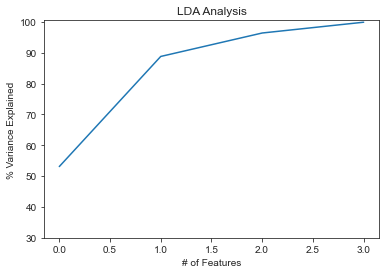

time: 1.12 s


In [33]:
X_lda = LDA_model_lineplot(None, X1, y_req)

In [34]:
model_lda, X_lda_4D = LDA_model(None, X1, y_req)

Explained variation per principal component : [0.53119097 0.3571063  0.07627817 0.03542455]
time: 562 ms


In [35]:
X_lda_4D.shape

(17861, 4)

time: 114 ms


In [36]:
# LDA Components are all uncorrelated
pd.DataFrame(X_lda_4D).cov()

,0,1,2,3
0,1.464329e+01,-9.553140e-16,-3.615572e-15,-9.493116e-15
1,-9.553140e-16,1.017196e+01,-1.119721e-14,5.564294e-16
2,-3.615572e-15,-1.119721e-14,2.958962e+00,-2.424240e-15
3,-9.493116e-15,5.564294e-16,-2.424240e-15,1.909647e+00


time: 125 ms


In [37]:
df_lda = pd.DataFrame(X_lda_4D, columns = ['x0', 'x1', 'x2', 'x3'])

time: 81.5 ms


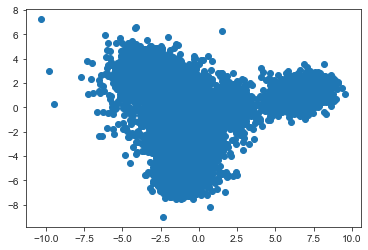

time: 297 ms


In [38]:
import matplotlib.pyplot as plt
plt.scatter(df_lda['x0'], df_lda['x1'])
plt.show()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_lda_4D, y_req, test_size=0.3, random_state=RANDOM_SEED)

time: 89.3 ms


Training time: 8.0207 s
Prediction time: 0.0063 s

Report:

Train accuracy: 0.9658
Test accuracy: 0.9677

               precision    recall  f1-score   support

      Potato       0.99      0.99      0.99      2244
Spring wheat       0.87      0.83      0.85       491
Winter wheat       0.95      0.97      0.96      1162
    Rapeseed       0.99      0.99      0.99      1100
      Forest       0.97      0.94      0.95       362

    accuracy                           0.97      5359
   macro avg       0.95      0.94      0.95      5359
weighted avg       0.97      0.97      0.97      5359



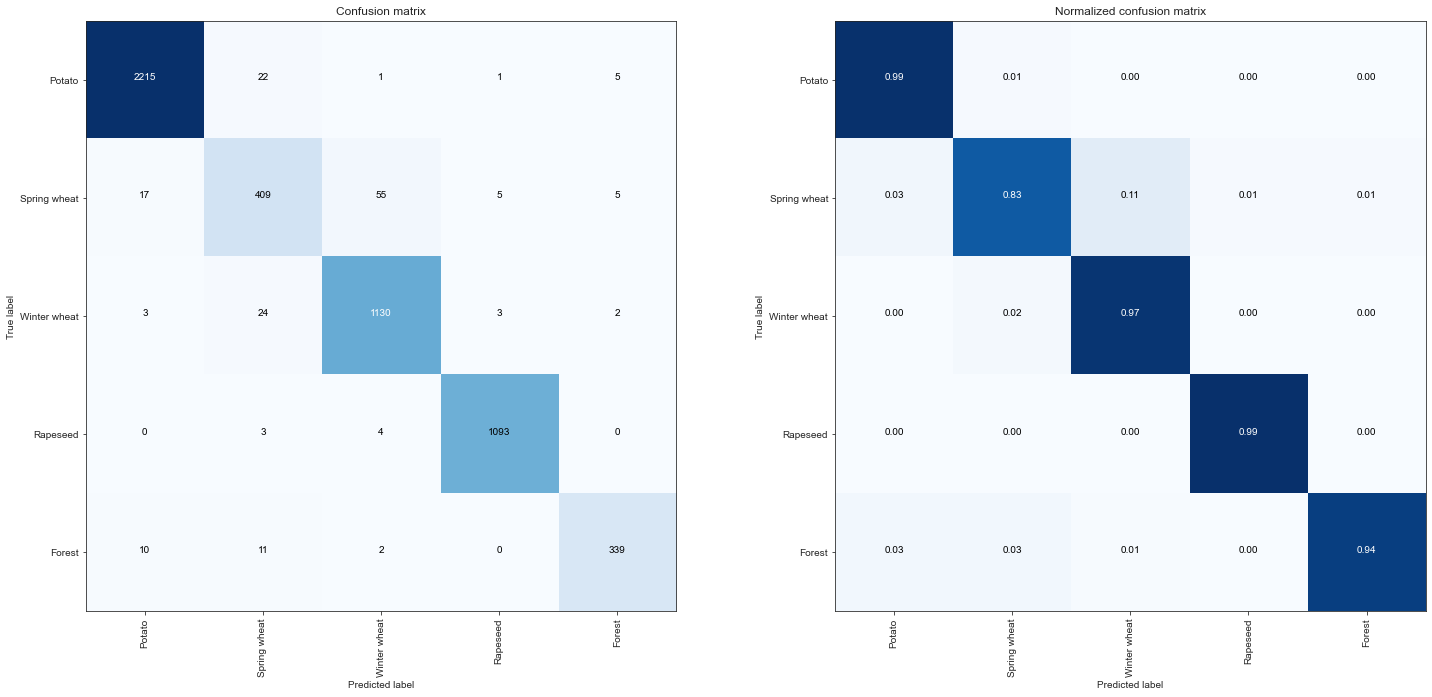

time: 8.9 s


In [40]:
# Train Logistic Regression classifier on dataset after LDA transformation
from sklearn.linear_model import LogisticRegression          
clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000)
clf_trained, _, accuracy_test, results_report, _ = evaluate_classifier(
    clf, X_train, X_test, y_train, y_test, ['Potato', 'Spring wheat', 'Winter wheat', 'Rapeseed', 'Forest'], feature_scale=False, plot_conf_matrix=True,
    print_classification_report=True)

In [41]:
# Get classfication report as pandas df
df_results = pd.DataFrame(results_report).transpose()  

# Round the values to 2 decimals
df_results = df_results.round(2).astype({'support': 'int32'})  

# Correct error when creating df (acc. is copied into 'precision')
df_results.loc[df_results.index == 'accuracy', 'precision'] = ''  

# Correct error when creating df (acc. is copied into 'recall')
df_results.loc[df_results.index == 'accuracy', 'recall'] = ''  

# Correct error when creating df (acc. is copied into 'recall')
df_results.loc[df_results.index == 'accuracy', 'recall'] = ''  

# The number of samples ('support') was incorrectly parsed in to dataframe
df_results.loc[df_results.index == 'accuracy', 'support'] = df_results.loc[
    df_results.index == 'macro avg', 'support'].values

# Print df in latex format (I normally add a /midrule above accuracy manually)
print(df_results.to_latex(index=True))  

\begin{tabular}{lllrr}
\toprule
{} & precision & recall &  f1-score &  support \\
\midrule
Potato       &      0.99 &   0.99 &      0.99 &     2244 \\
Spring wheat &      0.87 &   0.83 &      0.85 &      491 \\
Winter wheat &      0.95 &   0.97 &      0.96 &     1162 \\
Rapeseed     &      0.99 &   0.99 &      0.99 &     1100 \\
Forest       &      0.97 &   0.94 &      0.95 &      362 \\
accuracy     &           &        &      0.97 &     5359 \\
macro avg    &      0.95 &   0.94 &      0.95 &     5359 \\
weighted avg &      0.97 &   0.97 &      0.97 &     5359 \\
\bottomrule
\end{tabular}

time: 139 ms


In [43]:
# Get Permutation Importance Values For Individual LDA components
def explain(): 
    perm = PermutationImportance(clf_trained, random_state=1).fit(X_test, y_test)
    #eli5.explain_weights(perm, feature_names=list(feature_names), target_names=class_names)

    df_explanation = eli5.formatters.as_dataframe.explain_weights_df(perm)
    df_explanation.sort_values(by=['weight'], inplace = True, ascending = False)
    display(df_explanation)
    df_explanation.drop(columns = ['std'], inplace = True)
    df_explanation.set_index('feature').plot(figsize=(10,5), grid=True)

time: 91.5 ms


,feature,weight,std
0,x1,0.317373,0.002400
1,x0,0.305953,0.003774
2,x2,0.091957,0.001948
3,x3,0.073484,0.001279


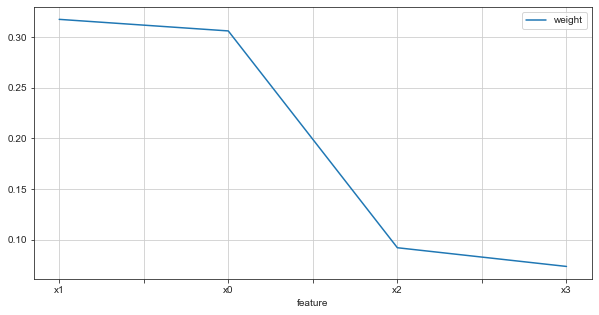

time: 355 ms


In [44]:
explain()

In [45]:
# Use eli5 to show weights for individual LDA components for individual crop types
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20
(eli5.show_weights(clf, target_names = ['Potato', 'Spring wheat', 'Winter wheat', 'Rapeseed', 'Forest']))

time: 303 ms


In [59]:
# X_test[17] is an instance of Winter wheat
eli5.show_prediction(clf_trained, X_test[17], show_feature_values=True, target_names = ['Potato', 'Spring wheat', 'Winter wheat', 'Rapeseed', 'Forest'])

time: 85.1 ms


In [253]:
def LDA_Sense(i):
    dict = {'feature': list(feature_names), 'weight': list(model_lda.coef_[i])}
    df_explanation = pd.DataFrame(dict)
    df_explanation = df_explanation.sort_values(by=['feature'])
    df_explanation['polarization'] = ''
    features = df_explanation['feature'].unique()
    for feature in features:
        if feature[-5:] == 'VV-VH':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
            df_explanation = df_explanation.replace(feature, feature[:-6])
        elif feature[-2:] == 'VV':
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
            df_explanation = df_explanation.replace(feature, feature[:-3])
        else:
            df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
            df_explanation = df_explanation.replace(feature, feature[:-3])

    df_explanation['weight'] = df_explanation['weight'].abs()
    data = df_explanation.loc[df_explanation['polarization'].isin(['VV', 'VH', 'VV-VH'])]
    plt.figure(figsize=(13, 4))
    plt.xticks(rotation=90, horizontalalignment='center')
    sns.set_context("talk")
    ax = sns.lineplot(x='feature', y='weight', hue='polarization', data=data, ci='sd')

time: 299 ms


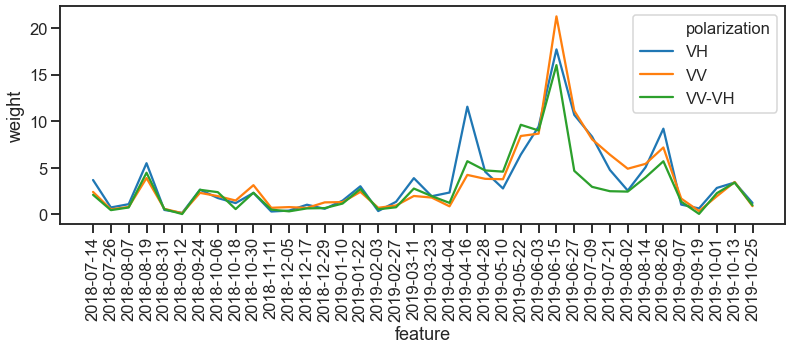

time: 953 ms


In [255]:
# Potato
LDA_Sense(0)

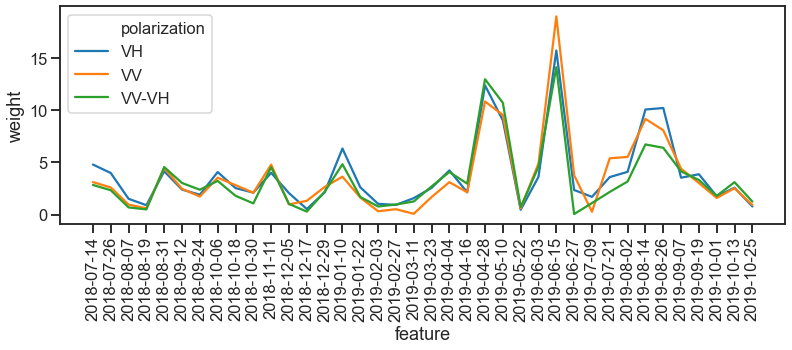

time: 883 ms


In [256]:
# Spring Wheat
LDA_Sense(1)

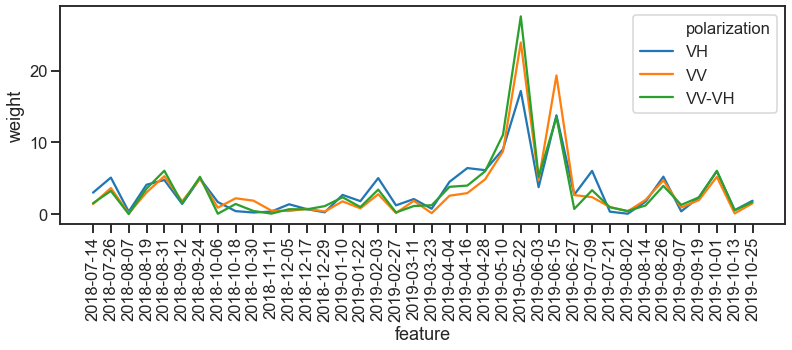

time: 941 ms


In [257]:
# Winter Wheat
LDA_Sense(2)

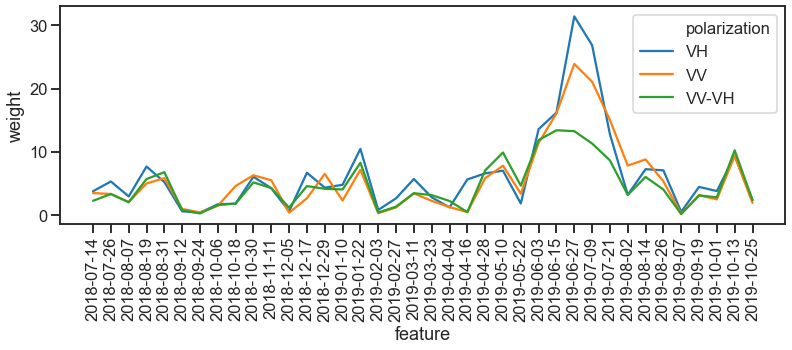

time: 918 ms


In [258]:
# Rapeseed
LDA_Sense(3)

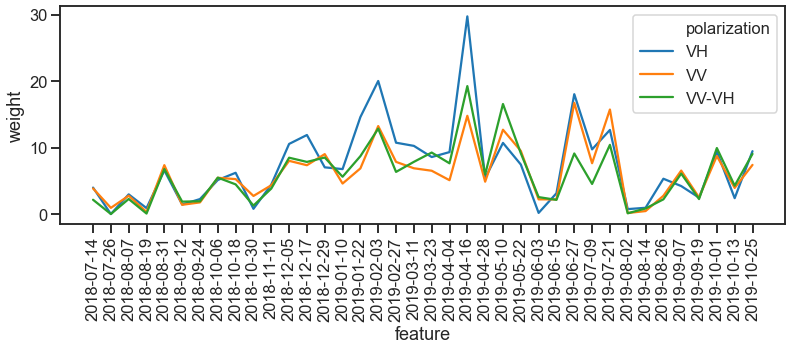

time: 1.27 s


In [231]:
# Forest
LDA_Sense(4)